*Exercise: Key Performance Indicators (KPIs): Define three time-dependent KPIs that you would include in
 a dashboard for the hub operator. These KPIs must provide an immediate overview of the current
 hub operation and how it is doing in terms of utilization or other business-related aspects. Briefly
 explain the rationale behind selecting each KPI, explain why you have chosen it and, where
 needed, provide references. Calculate hourly values for the selected KPIs and visualize them over
 time. Which trends do you observe? How do you explain them?*
 

1. **Total Drawn Power in kW**
This KPI is particularly relevant for monitoring energy consumption and therefore probably the main source of costs for the site. If the operator knows his electricity costs, he can also use this KPI to make further economic calculations. Consumption transparency also enables choosing the most suitable energy supplier or contemplating about pricing measures such as dynamic pricing. Another interesting idea could be to assess the integration of on-site renewable energy technologies, e.g. solar panels, to offset peak energy costs.

2. **Utilization Rate**
This basic KPI is helpful in identifying peak and minimum utilization times, which could for examplesupport decisions toward a novel pricing rationale. An early identification of trends with this KPI also supports well-funded long term decisions. Additionally, comparisons between the two sites allow the evaluation of different characteristics of those.

3. **Idle Rate**
This KPI uncovers another aspect of running an EV charging site, which is handling EVs that block stations but are not charging. If the operator can for example identify times in which both utilization rate and idle rate are high, they can consider measures against EVs blocking the station after being fully charged, like penalties, time-sensitive fees, or shorter maximum session durations.


Trends:



Locator attempting to generate 5498 ticks ([18665.875, ..., 18894.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5498 ticks ([18665.875, ..., 18894.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5498 ticks ([18665.875, ..., 18894.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5498 ticks ([18665.875, ..., 18894.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5498 ticks ([18665.875, ..., 18894.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5498 ticks ([18665.875, ..., 18894.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5498 ticks ([18665.875, ..., 18894.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5498 ticks ([18665.875, ..., 18894.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5

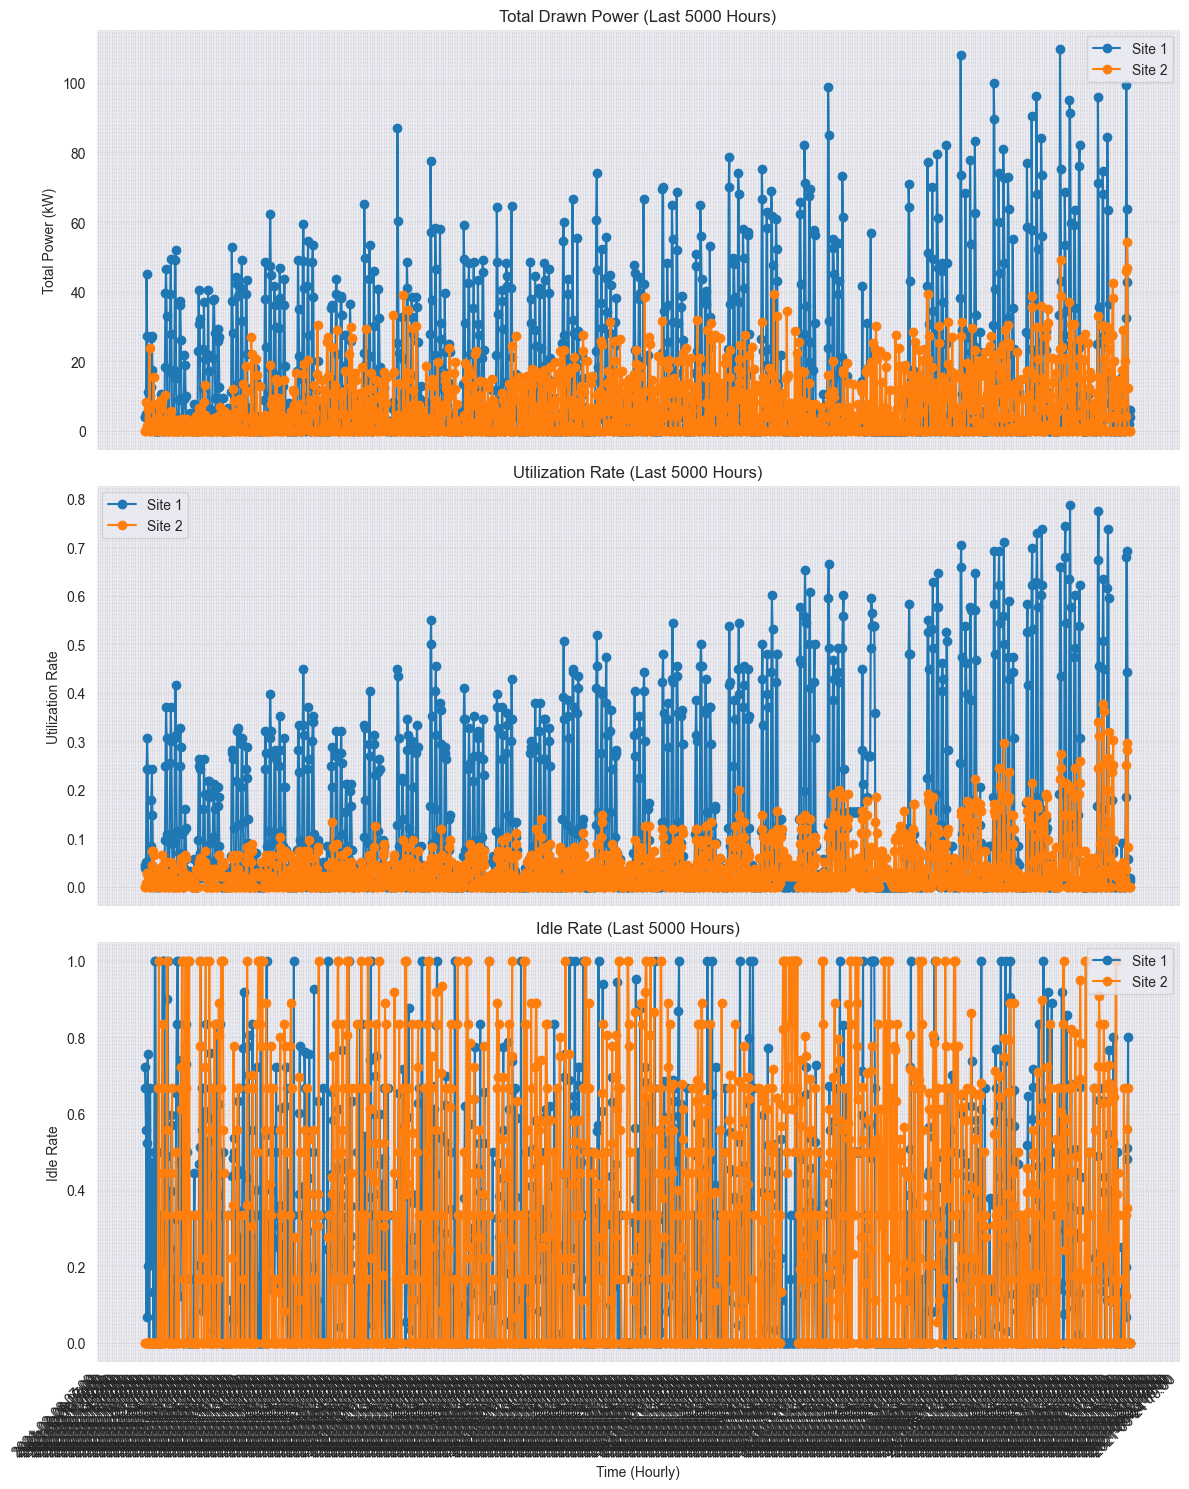

In [29]:
# Wieviele Stunden sollen in der Rückschau betrachtet werden?

def plot_KPIs(last_x_hours: int):
    #imports
    import pandas as pd
    from matplotlib import pyplot as plt
    import numpy as np
    import matplotlib.dates as mdates
    
    #############################################################################
    #data operations
    df = pd.read_csv('../data/processed/charging_sessions_cleaned.csv')
    df['connectionTime'] = pd.to_datetime(df['connectionTime'])
    df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
    df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])
    # Use disconnectTime as fallback for doneChargingTime
    df.loc[df['doneChargingTime'].isna(), 'doneChargingTime'] = df['disconnectTime']
    
    #############################################################################
    #conditional compression
    if last_x_hours > 168:
        compression = True
    else:
        compression = False
    
    ###############################################################################
    
    # Determine the last X hours
    end_time_plot_1 = df['doneChargingTime'].max()
    start_time_plot_1 = end_time_plot_1 - pd.Timedelta(hours=last_x_hours)
    
    # Filter sessions occurring in the last 120 hours
    filtered_df_plot_1 = df[
        (df['doneChargingTime'] >= start_time_plot_1) & 
        (df['connectionTime'] <= end_time_plot_1)
    ]
    
    # Create an array to store total charging power for each site and hour
    hours_plot_1 = pd.date_range(start=start_time_plot_1, end=end_time_plot_1, freq='h')        #hours_plot_1 = 170
    power_by_site = np.zeros((2, len(hours_plot_1)))                                            #power_by_site -> [2 : 170]
    
    # Loop through the sessions and accumulate power for each hour and site
    for _, row in filtered_df_plot_1.iterrows():
        site_idx = row['siteID'] - 1  # Assuming siteID is 1 or 2
        for i, hour in enumerate(hours_plot_1):
            if row['connectionTime'] <= hour and row['doneChargingTime'] > hour:
                power_by_site[site_idx, i] += row['chargingPower']
    
    #conditional compression
    if compression:
        
        while (power_by_site.shape[1] % 3 != 0):
            power_by_site = power_by_site[:, 1:]
            start_time_plot_1 += pd.Timedelta(hours=1)
        
        binned_power_by_site = power_by_site.reshape(2, -1, 3).mean(axis=2)
        power_by_site = binned_power_by_site
        
        binned_hours_plot_1= pd.date_range(
            start=start_time_plot_1, 
            end=end_time_plot_1, 
            freq='3h'
        )
        hours_plot_1 = binned_hours_plot_1
    
    ###############################################################################
    
    # Filter for the last x hours
    end_time_plot_2 = df['disconnectTime'].max()
    start_time_plot_2 = end_time_plot_2 - pd.Timedelta(hours=last_x_hours)
    
    filtered_df_plot_2 = df[
        (df['disconnectTime'] >= start_time_plot_2) & 
        (df['connectionTime'] <= end_time_plot_2)
    ]
    
    # Calculate total available stations per site
    total_stations_per_site = filtered_df_plot_2.groupby('siteID')['stationID'].nunique()
    
    # Create an array to store utilization rates for each site and hour
    hours = pd.date_range(start=start_time_plot_2, end=end_time_plot_2, freq='h')
    utilization_rates = np.zeros((2, len(hours)))
    
    # Loop through the sessions and calculate utilization for each hour and site
    for i, hour in enumerate(hours):
        for site in [1, 2]:
            # Filter active sessions for the current site and hour
            active_sessions_plot_2 = filtered_df_plot_2[
                (filtered_df_plot_2['siteID'] == site) &
                (filtered_df_plot_2['connectionTime'] <= hour) &
                (filtered_df_plot_2['disconnectTime'] > hour)
            ]
            # Calculate utilization rate
            num_active_sessions = len(active_sessions_plot_2)
            total_stations = total_stations_per_site[site]
            utilization_rates[site - 1, i] = num_active_sessions / total_stations
    
    #conditional compression
    if compression:
        
        while (utilization_rates.shape[1] % 3 != 0):
            utilization_rates = utilization_rates[:, 1:] 
            start_time_plot_2 += pd.Timedelta(hours=1)
        
        binned_utilization_rates = utilization_rates.reshape(2, -1, 3).mean(axis=2)
        utilization_rates = binned_utilization_rates
        
        binned_hours = pd.date_range(
            start=start_time_plot_2, 
            end=end_time_plot_2, 
            freq='3h'
        )
        hours = binned_hours #binning is done when calculating idle rates

            
    ###############################################################################
    
    # Filter for the last x hours
    end_time_plot_3 = df['disconnectTime'].max()
    start_time_plot_3 = end_time_plot_3 - pd.Timedelta(hours=last_x_hours)
    
    filtered_df_plot_3 = df[
        (df['disconnectTime'] >= start_time_plot_3) & 
        (df['connectionTime'] <= end_time_plot_3)
    ]
    
    # Create an array to store idle rates for each site and hour
    hours = pd.date_range(start=start_time_plot_3, end=end_time_plot_3, freq='h')
    idle_rates = np.zeros((2, len(hours)))
    
    # Loop through each hour and calculate idle rate for each site
    for i, hour in enumerate(hours):
        for site in [1, 2]:
            # Filter sessions for the current site
            site_df = filtered_df_plot_3[filtered_df_plot_3['siteID'] == site]
            
            # Zähler: Number of sessions in idling at that time
            idle_sessions = site_df[
                (site_df['doneChargingTime'] <= hour) &
                (site_df['disconnectTime'] > hour)
            ]
            num_idle_sessions = len(idle_sessions)
            
            # Nenner: Number of all sessions (charging or idling) at that time
            active_sessions_plot_3 = site_df[
                (site_df['connectionTime'] <= hour) &
                (site_df['disconnectTime'] > hour)
            ]
            num_active_sessions = len(active_sessions_plot_3)
            
            # Calculate idle rate (handle edge case of no active sessions)
            if num_active_sessions > 0:
                idle_rates[site - 1, i] = num_idle_sessions / num_active_sessions
            else:
                idle_rates[site - 1, i] = 0
    
    #conditional compression       
    if compression:
        
        while (idle_rates.shape[1] % 3 != 0):
            idle_rates = idle_rates[:, 1:] 
            start_time_plot_3 += pd.Timedelta(hours=1)        
        
        binned_idle_rates = idle_rates.reshape(2, -1, 3).mean(axis=2)
        idle_rates = binned_idle_rates
        
        binned_hours = pd.date_range(
            start=start_time_plot_3, 
            end=end_time_plot_3, 
            freq='3h'
        )
        hours = binned_hours    
                
    ###############################################################################
    # Plotting
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    #Total Drawn Power
    axes[0].plot(hours_plot_1, power_by_site[0], label='Site 1', linestyle='-', marker='o')
    axes[0].plot(hours_plot_1, power_by_site[1], label='Site 2', linestyle='-', marker='o')
    axes[0].set_title('Total Drawn Power (Last ' + str(last_x_hours) + ' Hours)')
    axes[0].set_ylabel('Total Power (kW)')
    axes[0].legend()
    axes[0].grid(color='lightgray', linestyle='--', linewidth=0.5)
    
    #Utilization Rate
    axes[1].plot(hours, utilization_rates[0], label='Site 1', linestyle='-', marker='o')
    axes[1].plot(hours, utilization_rates[1], label='Site 2', linestyle='-', marker='o')
    axes[1].set_title('Utilization Rate (Last ' + str(last_x_hours) + ' Hours)')
    axes[1].set_ylabel('Utilization Rate')
    axes[1].legend()
    axes[1].grid(color='lightgray', linestyle='--', linewidth=0.5)
    
    #idle rate
    axes[2].plot(hours, idle_rates[0], label='Site 1', linestyle='-', marker='o')
    axes[2].plot(hours, idle_rates[1], label='Site 2', linestyle='-', marker='o')
    axes[2].set_title('Idle Rate (Last ' + str(last_x_hours) + ' Hours)')
    axes[2].set_xlabel('Time (Hourly)')
    axes[2].set_ylabel('Idle Rate')
    axes[2].legend()
    axes[2].grid(color='lightgray', linestyle='--', linewidth=0.5)
    
    #x-axis ticks
    if last_x_hours <= 300:
        axes[2].xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Major ticks every 6 hours
    else:
        axes[2].xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Major ticks every 12 hours
    axes[2].xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Minor ticks every 1 hour
    axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Format for major ticks
    
    #Rotate x labels
    for ax in axes:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
  
plot_KPIs(last_x_hours = 5000)